# Generative Deep Learning

## Summary

- Neural Style Transfer
- Generative Adversarial Networks (GAN)

## Neural Style Transfer

### Neural Style Transfer in a nutshell

- Reproduce an image with a new artistic style provided by another image.
- Blend a *content* image and a *style reference* image in a stylized output image.
- First described in [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) by Gatys et al (2015). Many refinements and variations since.

### Example (Prisma app)

[![Prisma style transfer example](images/style_transfer_prisma.png)](https://harishnarayanan.org/writing/artistic-style-transfer/)

### Underlying idea: loss minimization

![Content loss](images/content-loss.png)
![Style loss](images/style-loss.png)
![Total loss](images/total-loss.png)

### The content loss

- Content = high-level structure of an image.
- Can be captured by the upper layer of a convolutional neural network.
- Content loss for a layer = distance between the feature maps of the content and generated images.

### The style loss

- Style = low-level features of an image (textures, colors, visual patterns).
- Can be captured by using correlations across the different feature maps (filter responses) of a convnet.
- Feature correlations are computed via a Gram matrix (outer product of the feature maps for a given layer).
- Style loss for a layer = distance between the Gram matrices of the feature maps for the style and generated images.

### The total variation loss

- Sum of the absolute differences for neighboring pixel-values in an image. Measures how much noise is in the image.
- Encourage spatial continuity in the generated image (denoising).
- Act as a regularization loss.

### Gradient descent

- Objective: minimize the total loss.
- Optimizer: [L-BFGS](http://aria42.com/blog/2014/12/understanding-lbfgs) (original choice made by Gatys et al.) or Adam.

![Animation of style transfer](images/style_transfer_animated.gif)

## Generative Adversarial Networks (GAN)

### GAN in a nutshell

- Simultaneously train two models:
  - One tries to generate realistic data.
  - The other tries to discriminate between real and generated data.
- Each model is trained to best the other.
- First described in [Generative Adversarial Nets
](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) by Goodfellow et al. (2014).
- [NIPS 2016 Tutorial](https://arxiv.org/abs/1701.00160)


[![GAN overview](images/gan1.png)](https://www.tensorflow.org/tutorials/generative/dcgan)

[![GAN process](images/gan2.png)](https://www.tensorflow.org/tutorials/generative/dcgan)

### Training process

- The generator creates images from random noise.
- Generated images are mixed with real ones.
- The discriminator is trained on these mixed images.
- The generator's parameters are updated in a direction that makes the discriminator more likely to classify generated data as "real".

### Example: generate handwritten digits

We'll use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Python version: 3.7.5


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    BatchNormalization,
    LeakyReLU,
    Reshape,
    Conv2DTranspose,
    Conv2D,
    Flatten,
    Dropout,
)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

TensorFlow version: 2.0.0
Keras version: 2.2.4-tf


In [4]:
# Load only the training set for MNIST
(train_images, train_labels), (_, _) = mnist.load_data()

print(f"Training images: {train_images.shape}. Training labels: {train_labels.shape}")

Training images: (60000, 28, 28). Training labels: (60000,)


In [5]:
# Change pixel values from (0, 255) to (0, 1)
x_train = train_images.astype("float32") / 255

# Make sure images have shape (28, 28, 1) to apply convolution
x_train = np.expand_dims(x_train, -1)

print(f"x_train: {x_train.shape}")

x_train: (60000, 28, 28, 1)


In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Creating a generator

The generator uses `Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). A `Dense` layer takes this seed as input, then upsamples several times until the desired image size of 28x28x1 is reached.

In [7]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(
        Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False)
    )
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(
        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False)
    )
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(
        Conv2DTranspose(
            1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"
        )
    )
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [8]:
# Create the generator
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

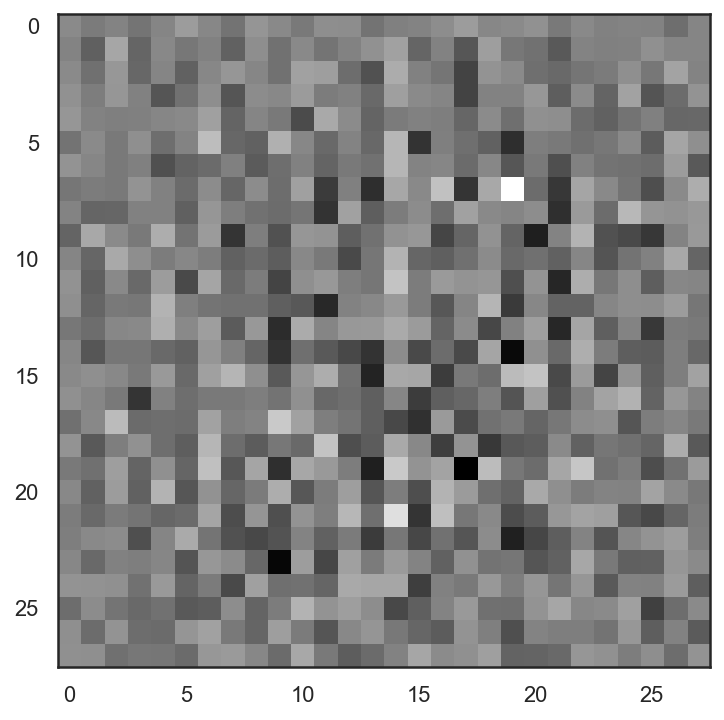

In [9]:
# Use the (untrained) generator to create an image from noise
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

with sns.axes_style("white"):  # Temporary hide Seaborn grid line
    plt.figure(figsize=(6, 6))
    plt.imshow(generated_image[0, :, :, 0], cmap="gray")
plt.show()

### Creating a discriminator

The discriminator is based on a standard CNN architecture. This model will be trained to output positive values for real images, and negative values for fake images.

In [10]:
def make_discriminator_model():
    model = Sequential()
    model.add(
        Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1])
    )
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [12]:
# Classify the first generated image
decision = discriminator(generated_image)

# Convert TF tensor to scalar
print(f"Discriminator prediction: {np.mean(decision):.05f}")

Discriminator prediction: 0.00205


### Discriminator loss

This function quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [13]:
# Use cross-entropy loss
cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

This function quantifies how well the generator was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [17]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [18]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [19]:
train(train_dataset, EPOCHS)

AttributeError: 'function' object has no attribute 'clear_output'

### Specificities and gotchas

- A GAN is a dynamic system that evolves at each training step.
- Interestingly, the generator never sees images froms the training set directly: all its informations come from the discriminator.
- Training can be tricky: noisy generated data, vanishing gradients, domination of one side...
- GAN convergence theory is an active area of research.
- [GAN Open Questions](https://distill.pub/2019/gan-open-problems/)

### GAN progress on face generation

[![GAN progress from 2014 to 2018](images/gan_2014_2018.jpg)](https://twitter.com/goodfellow_ian/status/1084973596236144640)

### The GAN landscape

[![GAN flavours](images/gan_flavours.png)](https://blog.floydhub.com/gans-story-so-far/)

### Some GAN flavours

- [DCGAN](https://arxiv.org/abs/1511.06434) (2016): use deep convolutional networks for generator and discriminator.
- [CycleGAN](https://arxiv.org/abs/1703.10593v6) (2017): image-to-image translation in the absence of any paired training examples.
- [StyleGAN](https://arxiv.org/abs/1812.04948) (2019): fine control of output images.
- [GAN - The Story So Far](https://blog.floydhub.com/gans-story-so-far/)

### GAN use cases: not just images!

- Writing a novel "in the style of an author".
- [Generating music](https://arxiv.org/abs/1805.07848) ([samples](https://www.youtube.com/watch?v=vdxCqNWTpUs)).
- Generating realistic passwords for hackers.
- Generating videos ([example](https://www.youtube.com/watch?time_continue=3&v=ab64TWzWn40&feature=emb_logo)).
- [Generating video game levels](https://arxiv.org/abs/1910.01603).
- ...